In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from math import trunc
from datetime import datetime, date, timedelta
import os
%matplotlib inline

In [9]:
directory = '../data/aggregates/'

# CTIS data collected by CMU and Facebook:
US_ML = pd.concat([pd.read_csv(os.path.join(directory, filename)) for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])

regions1 = US_ML.state.unique()

In [10]:
# Ground truth of serology data from CDC:
directory1 = '../data/'
US_official = pd.read_csv(os.path.join(directory1, "Nationwide_Commercial_Laboratory_Seroprevalence_Survey.csv"))

# NaNs in the database are represented by 777. We remove the empty rows.
US_official['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'] = US_official['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'].replace(777, np.nan)
US_official.drop(US_official[US_official['Round']>30].index,inplace=True)

US_official.drop(US_official[US_official['Estimated cumulative infections count'].isna()].index,inplace=True)
US_official['Estimated cumulative infections count'] = US_official['Estimated cumulative infections count'].apply(lambda x: int(x.replace(",","")))

regions2 = US_official.Site.unique()

In [11]:
def format_date(date_string, start_end):
    if len(date_string) > 25:
        start_month_day_year, end_month_day_year =  list(map(lambda x: x.strip(), date_string.split(' - ')))
        start_month_day, start_year = start_month_day_year.split(', ')
        end_month_day, end_year = end_month_day_year.split(', ')
        start_date = datetime.strptime(start_month_day + ' ' + start_year,'%b %d %Y')
        end_date = datetime.strptime(end_month_day + ' ' + end_year,'%b %d %Y')
    else:
        month_day, year = date_string.split(', ')
        start_month_day, end_month_day = list(map(lambda x: x.strip(), month_day.split(' - ')))
        start_date = datetime.strptime(start_month_day + ' ' + year, '%b %d %Y')
        end_date = datetime.strptime(end_month_day + ' ' + year, '%b %d %Y')
    if start_end == 'start':
        return start_date.strftime('%Y-%m-%d')

    else:
        return end_date.strftime('%Y-%m-%d')

In [12]:
# Save start and end dates of rounds:
US_official['start_date'] = US_official['Date Range of Specimen Collection'].map(lambda x: format_date(x, 'start'), na_action='ignore')
US_official['end_date'] = US_official['Date Range of Specimen Collection'].map(lambda x: format_date(x, 'end'), na_action='ignore')

In [13]:
US_official['days between rounds'] = US_official['end_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if (type(x)== str) else timedelta(days=14)) - US_official['start_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if (type(x)== str) else timedelta(days=0))
US_official['days between rounds'] = US_official['days between rounds'].map(lambda x: x.days + 1)

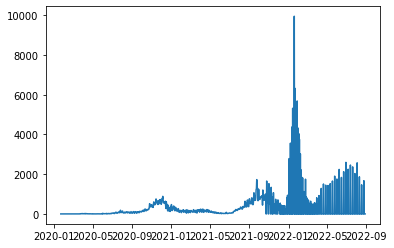

In [14]:
# Official data from Our World in Data:
US_cases = pd.read_csv(os.path.join(directory1, "United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv"))

#We adapt the date to the format we are using (yyyy-mm-dd):
US_cases['submission_date'] = US_cases['submission_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

US_cases['new_case'] = US_cases['new_case'].apply(lambda x: int(x.replace(",","")))
US_cases['tot_death'] = US_cases['tot_death'].apply(lambda x: int(x.replace(",","")))

regions3 = US_cases.state.unique()

# Example to see data: Arkansas
data = US_cases[US_cases['state'] == 'AK'].sort_values(by='submission_date') #Take data chronologically
plt.plot( data['submission_date'], data['new_case']) #Plot of total cases in Arkansas

plt.show()

In [15]:
# state_alphaCode sets the codes used to identify the states:
states = pd.read_csv(os.path.join(directory1, "State_codes.csv"))
states = states.drop(columns=['Numeric Code  '], axis=1)
states = states.rename(columns={' Name ' : 'State', ' Alpha Code ': 'Alpha Code'})
states.State = states.State.apply(lambda s: s.strip().capitalize())
states_unformatted = states.to_dict('records')
state_alphaCode = dict()

for unformatted_element in states_unformatted:
    state_alphaCode[unformatted_element['State']] = unformatted_element['Alpha Code'].strip()
    
# Add state codes in US_ML:
US_ML['state code']  = US_ML['state'].map(lambda x: x.capitalize()).replace(state_alphaCode)

In [16]:
# Definite list of states to be used:
regions = list(US_ML['state code'].unique())
regions.sort()

In [17]:
# COVID-19 cases estimations via wastewater SARS-CoV-2 concentration.
# WW_cases is the estimation for total infected population throughout time
WW_cases = pd.read_csv(os.path.join(directory1, "ww_estimate_infections.csv"))
WW_cases.drop(labels='id',axis=1,inplace=True) #We drop the states' id

WW_cases['state code']  = WW_cases['Country'].map(lambda x: x.capitalize()).replace(state_alphaCode) #adds the state code
#There are colonies, not only states and DC. remove the colonies:
for state_i in WW_cases['state code'].unique():
    if state_i not in state_alphaCode.values():
        WW_cases.drop(WW_cases[WW_cases['state code']==state_i].index,inplace=True)

In [18]:
WW_new = pd.DataFrame(columns=['site','date','cases'])
dates_WW = WW_cases.columns[1:-1]
counter = 0
for state in WW_cases['state code'].unique():
    WW_new.loc[counter] = [state,dates_WW[0],WW_cases[WW_cases['state code']==state][dates_WW[0]].iloc[0]]
    counter += 1
    for date_i in range(1,len(dates_WW)):
        WW_new.loc[counter] = [state,dates_WW[date_i],WW_cases[WW_cases['state code']==state][dates_WW[date_i]].iloc[0]]
        counter += 1
WW_new.rename(columns={'cases': 'ww_cases'}, inplace=True) #rename "cases" so that it's not confused with other data
WW_cases = WW_new
#Now we have the same format as in the other dataframes

# Classes

In [20]:
class AcumulatedIncidences:

    """dataframes to be used"""
    US_ML = US_ML
    US_official = US_official
    US_cases = US_cases
    WW_cases = WW_cases
    phi = (1+math.sqrt(5))/2 # for the purpose of making graph look nice
    regions = list(US_ML['state code'].unique()) #given all datasets have rows associated to these states, we will use these
    #Remember: regions=list(US_ML['state code'].unique())

    """
    define a start_date and an end_date to define the interval of study
    """


    def __init__(self,signals=['p_cli','p_rf','p_XGB','p_glm','new_case','ww_cases']):
        #signals are explanatory variables
        self.signals = signals
        self.incidenceVectors = dict()
        self.referenceVector = np.array([])
        self.incidenceDataFrame = None
        self.correlationFactors = dict()

    def getStartDate(self, d, region):
        #d = the date at the start of our interval
        # Finds the first available 'end_date' in the interval [d,Inf)
        start_date = US_official[(US_official['end_date'] >= d) & (US_official['Site'] == region)]['end_date'].iloc[0]
        return start_date


    def getEndDate(self, d, region):
        # Finds the last available 'end_date' in the interval (Inf,d]
        end_date = US_official[(US_official['end_date'] <= d) & (US_official['Site'] == region)]['end_date'].iloc[-1]
        return end_date


    def calculateDaysBetween(self, date1, date2):
        #returns the days between date1 and date2
        try:
            start_date = datetime.strptime(date1, '%Y-%m-%d')
            end_date = datetime.strptime(date2, '%Y-%m-%d')
            days = (end_date-start_date).days
        except TypeError:
            days = None
        return days

    def calculateVectorEntryForRegion(self, region, signal, start_date, end_date):
        #Gets number of infections for "region" between specified dates, using the specified model "signal". These values are the elements of the incidence vectors
        start_date = self.getStartDate(start_date,region)
        end_date = self.getEndDate(end_date,region)
        if signal in US_ML.columns:
            data = US_ML[(US_ML['date'] >= start_date) & (US_ML['date'] <= end_date) & (US_ML['state code'] == region)]
            cumulativeIntegral = data[signal].sum()
        elif signal in US_cases.columns:
            data = US_cases[(US_cases['submission_date'] >= start_date) & (US_cases['submission_date'] <= end_date) & (US_cases['state'] == region)]
            cumulativeIntegral = data[signal].sum()
        elif signal in WW_cases.columns:
            data = WW_cases[(WW_cases['date'] >= start_date) & (WW_cases['date'] <= end_date) & (WW_cases['site'] == region)]
            cumulativeIntegral = data[signal].sum()
        return cumulativeIntegral

    def MLEcoefs(self, reference_vector, incidence_matrix):
        # Estimates the coefficients of Linear Regression
        XtX = np.dot(incidence_matrix.T,incidence_matrix)
        Xty = np.dot(incidence_matrix.T,reference_vector)
        return np.linalg.solve(XtX,Xty)

In [21]:
class TemporalIncidences(AcumulatedIncidences):

    def __init__(self, region, interval_type='from0', signals=['p_cli','p_rf','p_XGB','p_glm','new_case','ww_cases'], rounds=None):
        self.region = region
        self.interval_type = interval_type
        self.incidenceMatrix = np.empty((0,len(signals)+1))
        if rounds is None:
            self.rounds = list(US_official[US_official['Site']==self.region]['Round'])
        else:
            self.rounds = rounds
        AcumulatedIncidences.__init__(self,signals)


    def calculateVectors(self):
        #Computes the incidence vectors: they're dicts where each pair of dates (start,end) has a value (that value is the % of infected people between those rounds and the selected region)
        for start_date, end_date in self.zipRounds():
            self.incidenceVectors['{0} {1}'.format(start_date, end_date)] = np.array([])
            for signal in self.signals:
                self.incidenceVectors['{0} {1}'.format(start_date, end_date)] = np.append(self.incidenceVectors['{0} {1}'.format(start_date, end_date)], self.calculateVectorEntryForRegion(self.region, signal, start_date, end_date))
        return self.incidenceVectors

    # single1 = Non-cumulative
    # from1 = Cumulative
    
    def zipRounds(self):
        #with this we can get the pairs of (start_date,end_date) with which we speccify the incidence vectors
        dates = list(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['end_date'])

        if self.interval_type == 'single1':
            return zip(dates[:-1], dates[1:])
        elif self.interval_type == 'from1':
            return zip([dates[0] for i in range(len(dates)-1)], dates[1:])
        else:
            raise ValueError('unknown type of interval has been used', self.interval_type)


    def addReferenceVector(self):
        self.referenceVector = np.array([])
        for start_date, end_date in self.zipRounds():
            cumulativeIntegral = US_official[(US_official['end_date'] == end_date) & (US_official['Site'] == self.region)]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'].iloc[0]
            self.referenceVector = np.append(self.referenceVector, cumulativeIntegral/100)
        return self.referenceVector

    def calculateIncidenceMatrix(self, normalize_everything=False):
        self.calculateVectors()
        self.incidenceMatrix = np.empty((0,len(self.signals)+1))
        for start_date, end_date in self.zipRounds():
            row = np.array([1]) # add a one if trying to add a coefficient
            row = np.append(row, self.incidenceVectors['{0} {1}'.format(start_date, end_date)])
            self.incidenceMatrix = np.vstack([self.incidenceMatrix, row])

        # Normilise tot_cases and ww_cases (or everything):
        to_normalize = self.signals if normalize_everything else ['new_case','ww_cases']
        for signal in to_normalize:
            if signal in self.signals:
                col_i = self.signals.index(signal)+1
                max_value = max(self.incidenceMatrix[:,col_i])
                self.incidenceMatrix[:,col_i] = self.incidenceMatrix[:,col_i]/max_value

        # Add days between data-points and real values:
        if self.interval_type == 'from1':
            # we have to remove the first column (constant)
            self.incidenceMatrix = np.delete(self.incidenceMatrix,0,1)
            a = np.array(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['end_date'][1:].map(lambda x: datetime.strptime(x, '%Y-%m-%d')))
            first = datetime.strptime(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['end_date'].iloc[0], '%Y-%m-%d')
            egunak = pd.array(a).map(lambda x: (x-first).days)
            self.incidenceMatrix = np.column_stack([ self.incidenceMatrix, egunak/max(egunak) ]) # weeks between rounds (float1 interval)
            self.incidenceMatrix = np.column_stack([ self.incidenceMatrix, np.array([US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'].iloc[0]/100 for i in range(len(a))]) ])

        elif self.interval_type == 'single1':
            a = np.array(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['end_date'][1:].map(lambda x: datetime.strptime(x, '%Y-%m-%d')))
            b = np.array(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['end_date'][:-1].map(lambda x: datetime.strptime(x, '%Y-%m-%d')))
            egunak = pd.array(a-b).map(lambda x: x.days)
            self.incidenceMatrix = np.column_stack([ self.incidenceMatrix, egunak/max(egunak) ]) # days between rounds (normilised)
            self.incidenceMatrix = np.column_stack([ self.incidenceMatrix, np.array(US_official[(US_official['Site'] == self.region) & (US_official['Round'].map(lambda x: x in self.rounds))]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'][:-1])/100 ]) # zati 100 ehunekoa delako

        return self.incidenceMatrix


    def estimate(self, only_coefs=False, dates=False):
        first_end_date = self.getStartDate('2020-01-01',self.region)
        end_dates = [first_end_date] + [end for (start,end) in self.zipRounds()]

        ref_vec = self.addReferenceVector()
        inc_mat = self.calculateIncidenceMatrix()
        coeff = self.MLEcoefs(ref_vec,inc_mat)
        if only_coefs==True:
            if dates==True:
                return (coeff,end_dates)
            else:
                return coeff
        else:
            estim = np.dot(inc_mat,coeff)
            if dates==True:
                return (estim,end_dates)
            else:
                return estim

In [22]:
class AllRegionsAllRounds(AcumulatedIncidences):
    """
    Works with multiple states at once. Used for nationwide models. The states used can be specified.
    """

    def __init__(self, interval_type='single1', states=None, signals=['p_cli','p_rf','p_XGB','p_glm','new_case','ww_cases']):
        self.interval_type = interval_type
        self.incidenceMatrix = np.empty((0,len(signals)+1))
        AcumulatedIncidences.__init__(self,signals)
        self.regions = regions if states==None else states

    def zipRounds(self,region):
        #with this we can get the pairs of (start_round,end_round) with which we speccify the incidence vectors
        dates = list(US_official[US_official['Site'] == region]['end_date'])

        if self.interval_type == 'single1':
            return zip(dates[:-1], dates[1:])
        elif self.interval_type == 'from1':
            return zip([dates[0] for i in range(len(dates)-1)], dates[1:])
        else:
            raise ValueError('unknown type of interval has been used', self.interval_type)

    def calculateIncidenceMatrix(self, normalize_everything=False):
        self.incidenceMatrix = np.empty((0,len(self.signals)+3))
        
        # Normilise tot_cases and ww_cases (or everything):
        to_normalize = self.signals if normalize_everything else ['new_case','ww_cases']
        for region in self.regions:
            temp_mat = np.empty((0,len(self.signals)+1))
            for start_date, end_date in self.zipRounds(region):
                row = np.array([1]) # add a one if trying to add an intercept
                for signal in self.signals:
                    row = np.append(row, self.calculateVectorEntryForRegion(region, signal, start_date, end_date))
                temp_mat = np.vstack([temp_mat, row])
            for signal in to_normalize:
                if signal in self.signals:
                    col_i = self.signals.index(signal)+1
                    max_value = max(temp_mat[:,col_i])
                    temp_mat[:,col_i] = temp_mat[:,col_i]/max_value
                    
            # Add real values and days between data-points:
            a = np.array(US_official[US_official['Site']==region]['end_date'][1:])
            b = np.array(US_official[US_official['Site']==region]['end_date'][:-1])
            first = US_official[US_official['Site']==region]['end_date'].iloc[0]
            if self.interval_type == 'from1':
                egunak = np.array([self.calculateDaysBetween(first,xa) for xa in a])
                refs = np.array([US_official[US_official['Site']==region]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'].iloc[0]/100 for i in range(len(a))])
            elif self.interval_type == 'single1':
                egunak = np.array([self.calculateDaysBetween(xb,xa) for (xa,xb) in zip(a,b)])
                refs = np.array([ xx/100 for xx in US_official[US_official['Site']==region]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'][:-1] ])
            temp_mat = np.column_stack([ temp_mat, egunak/egunak.max() ])
            temp_mat = np.column_stack([ temp_mat, refs ])
            self.incidenceMatrix = np.vstack([self.incidenceMatrix, temp_mat])
            
        if self.interval_type=='from1':
            self.incidenceMatrix = np.delete(self.incidenceMatrix,0,1)


        return self.incidenceMatrix

    def addReferenceVector(self):
        self.referenceVector = np.array([])
        for region in self.regions:
            for start_date, end_date in self.zipRounds(region):
                cumulativeIntegral = US_official[(US_official['end_date'] == end_date) & (US_official['Site'] == region)]['Rate (%) [All Ages Cumulative Prevalence, Rounds 1-30 only]'].iloc[0]
                self.referenceVector = np.append(self.referenceVector, cumulativeIntegral/100)
        return self.referenceVector


    def estimate(self, only_coefs=False, inc_mat=None):
        ref_vec = self.addReferenceVector()
        if type(inc_mat)==type(None):
            inc_mat = self.calculateIncidenceMatrix()
        coeff = self.MLEcoefs(ref_vec,inc_mat)
        if only_coefs==True:
            return coeff
        else:
            estim = np.dot(inc_mat,coeff)
            return estim

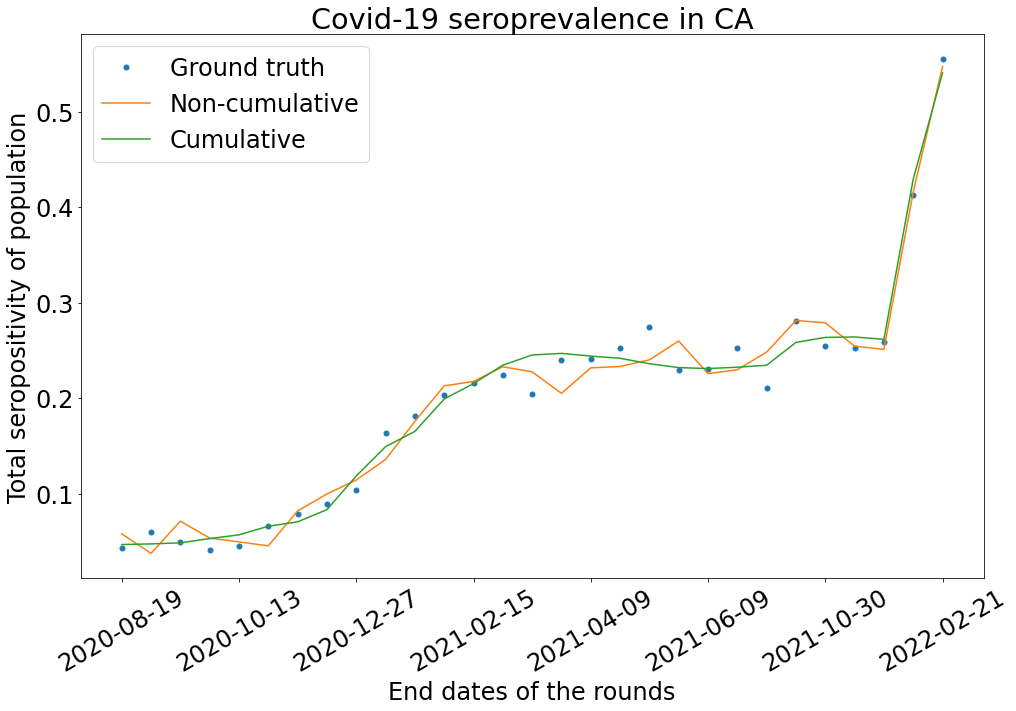

In [23]:
# Plot for CA:

intervals=['single1','from1']
state = 'CA'

state_instance = TemporalIncidences(state, interval_type='single1')
estim,end_dates = state_instance.estimate(dates=True)
ref_vec = state_instance.addReferenceVector()

fig = plt.figure(figsize = (5*(1+math.sqrt(5)),10))
plt.rc('font', size=24)
plt.plot(end_dates[1:], ref_vec, marker=".",markersize=10, linestyle="",label="Ground truth")
for interval in intervals:
    state_instance = TemporalIncidences(state, interval_type=interval)
    estim,end_dates = state_instance.estimate(dates=True)
    plt.plot(end_dates[1:],estim,label="{0}".format("Cumulative" if interval=="from1" else "Non-cumulative"))
plt.xticks(range(0,len(end_dates[1:]),4),rotation=30)
plt.xlabel("End dates of the rounds")
plt.ylabel("Total seropositivity of population")
plt.title("Covid-19 seroprevalence in {0}".format(state))
plt.legend()
plt.show()

In [25]:
# MARE of each state using the USA model:

intervals = ['single1','from1']

errorsUSA = dict()

## ALL STATES:
coefs = {'single1': np.array([-0.00114844, -0.10681324, 0.08665134, 0.00399453, -0.03067695, -0.03913617, 0.03321839, 0.09456043, 0.96245471]),
         'from1': np.array([0.01882006, 0.02679672, -0.02837665, 0.00382929, 0.32443316, 0.10035202, -0.15219441, 0.66817037])}

print('\tsingle1\tfrom1')
for state in regions:
    error_state = []
    for interval in intervals:
        state_instance = TemporalIncidences(state, interval_type=interval)
        ref_vec = state_instance.addReferenceVector()
        inc_mat = state_instance.calculateIncidenceMatrix()
        estim = np.dot(inc_mat,coefs[interval])

        mare = (np.abs(estim-ref_vec)/ref_vec).mean()
        error_state.append(mare)
    errorsUSA[state] = error_state
    print(state,':\t',error_state[0].round(5),'\t',error_state[1].round(5),sep='')

	single1	from1
AK:	0.34526	0.28817
AL:	0.10401	0.16968
AR:	0.16222	0.12849
AZ:	0.14387	0.16693
CA:	0.12085	0.15965
CO:	0.17767	0.24703
CT:	0.20098	0.42874
DC:	0.12045	0.42757
DE:	0.17839	0.16772
FL:	0.09987	0.28548
GA:	0.12822	0.30379
HI:	0.3729	0.45386
IA:	0.14584	0.29663
ID:	0.21099	0.44374
IL:	0.10478	0.35662
IN:	0.16816	0.16938
KS:	0.17641	0.37979
KY:	0.12984	0.20127
LA:	0.14488	0.43818
MA:	0.17037	0.24526
MD:	0.17554	0.16729
ME:	0.51727	0.7045
MI:	0.11289	0.20992
MN:	0.15777	0.31796
MO:	0.13427	0.15872
MS:	0.13858	0.12761
MT:	0.27973	0.58774
NC:	0.17454	0.20746
ND:	26.6687	45.33412
NE:	0.14739	0.33293
NH:	0.42303	0.65444
NJ:	0.08795	0.17081
NM:	0.14943	0.26827
NV:	0.08797	0.23602
NY:	0.15449	0.7606
OH:	0.19603	0.36333
OK:	0.1588	0.36675
OR:	0.23756	0.48075
PA:	0.12283	0.15762
RI:	0.20236	0.26443
SC:	0.09548	0.11284
SD:	0.19913	0.14642
TN:	0.08644	0.14121
TX:	0.14113	0.25344
UT:	0.14076	0.32184
VA:	0.16233	0.1819
VT:	0.67063	1.1053
WA:	0.24038	0.37333
WI:	0.10943	0.33868
WV:	0.2353

## Forecasting 

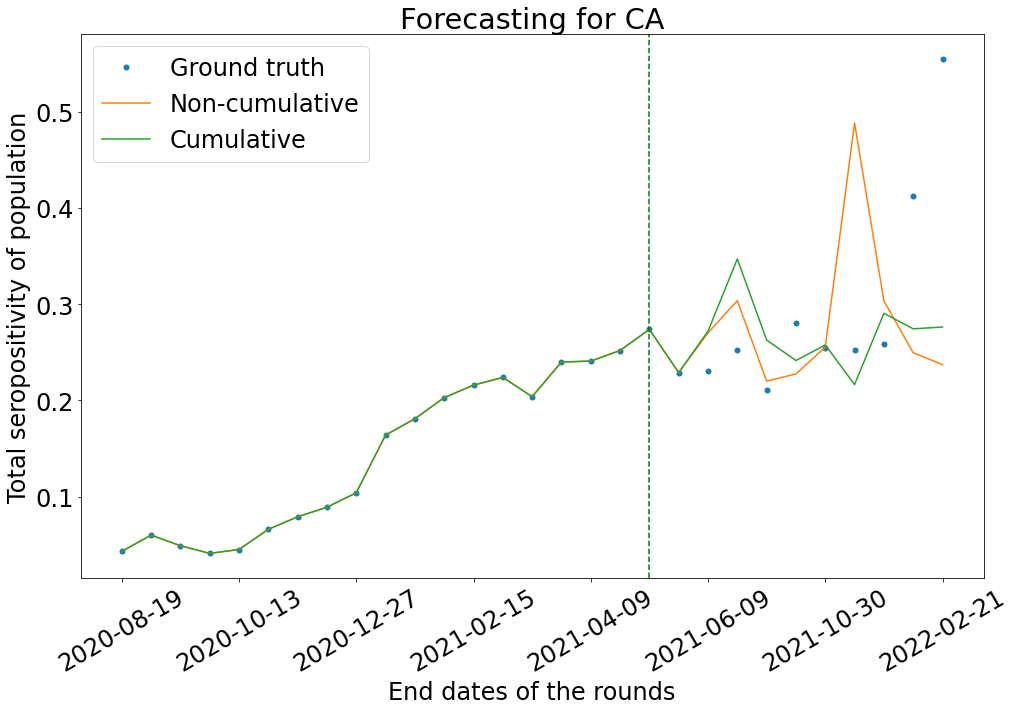

In [44]:
state = 'CA' #30 rounds
''''''
#This is just for the end dates and real values:
train_j = TemporalIncidences(state, interval_type='single1')
real_values = train_j.addReferenceVector()
est_single = real_values[:20]
est_from = real_values[:20]
coeff_j,end_dates = train_j.estimate(only_coefs=True,dates=True)
#

train_single = TemporalIncidences(state, interval_type='single1', rounds=list(range(1,21)))
coeff_single = train_single.estimate(only_coefs=True,dates=False)

train_from = TemporalIncidences(state, interval_type='from1', rounds=list(range(1,21)))
coeff_from = train_from.estimate(only_coefs=True,dates=False)


for j in range(20,29):
    # Estimate next step (j):
    #single1:
    test = TemporalIncidences(state, interval_type='single1', rounds=list(range(1,j+1)))
    inc_mat_test = test.calculateIncidenceMatrix()
    est_single_j = np.dot(inc_mat_test,coeff_single)
    est_single = np.append(est_single, np.array([est_single_j[-1]]))
    #from1:
    test = TemporalIncidences(state, interval_type='from1', rounds=list(range(1,j+1)))
    inc_mat_test = test.calculateIncidenceMatrix()
    est_from_j = np.dot(inc_mat_test,coeff_from)
    est_from = np.append(est_from, np.array([est_from_j[-1]]))
    
    train_single = TemporalIncidences(state, interval_type='single1', rounds=list(range(1,j+1)))
    coeff_single = train_single.estimate(only_coefs=True,dates=False)

    train_from = TemporalIncidences(state, interval_type='from1', rounds=list(range(1,j+1)))
    coeff_from = train_from.estimate(only_coefs=True,dates=False)


fig = plt.figure(figsize = (5*(1+math.sqrt(5)),10))
plt.rc('font', size=24)
plt.plot(end_dates[1:], real_values, marker=".",markersize=10, linestyle="",label='Ground truth')
plt.plot(end_dates[1:], est_single , label='Non-cumulative')
plt.plot(end_dates[1:], est_from , label='Cumulative')
plt.axvline(x=18, color='green', linestyle='--')
X_axis, Y_axis = np.arange(len(end_dates)), np.arange(0,30,2)       
plt.xticks(range(0,len(end_dates[1:]),4),rotation=30)
plt.xlabel("End dates of the rounds")
plt.ylabel("Total seropositivity of population")
plt.title('Forecasting for {0}'.format(state))
plt.legend()
plt.show()